In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns


movies='ml-latest/movies.csv'
ratings='ml-latest/ratings.csv'

df_movies=pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})
df_ratings=pd.read_csv(ratings, usecols=['userId','movieId','rating'], dtype={'userId':'int32','movieId':'int32','rating':'float32'})


In [4]:
def setup_recommender(data, model):
    model.fit(data)

In [5]:
#save for later use



# def recommender(movie_name, df_movies, data, model, n_recommendations):
#     # Find the best matching movie index using fuzzy matching
#     idx = process.extractOne(movie_name, df_movies['title'], score_cutoff=70)
#     if idx:
#         movie_idx = idx[2]
#         print(f"Movie Selected: {df_movies['title'][movie_idx]}, Index: {movie_idx}")
#         print('Searching for recommendations...')
#         distances, indices = model.kneighbors(data[movie_idx], n_neighbors=n_recommendations)
#         recommendations = [df_movies['title'][i] for i in indices.flatten() if i != movie_idx]
        
#         # Print all recommendations at once
#         print("\nRecommended Movies:")
#         for title in recommendations:
#             print(title)
#     else:
#         print("No matching movie found. Please try another name.")

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

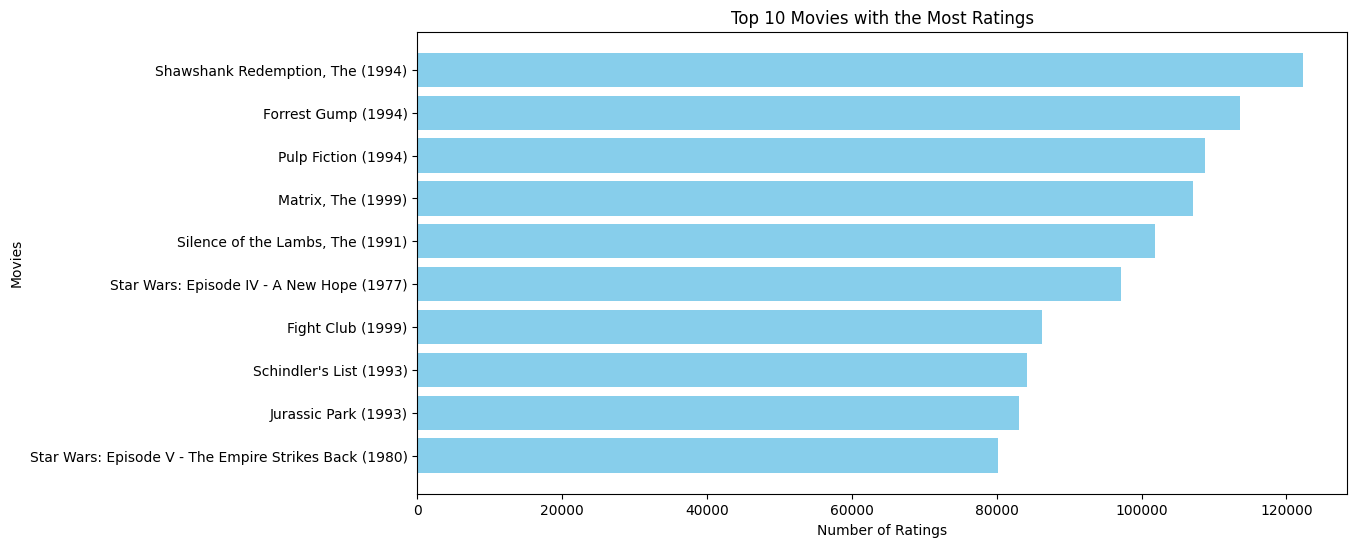

In [6]:
#Aggregate the ratings to count the number of ratings per movie
rating_counts = df_ratings.groupby('movieId').size().reset_index(name='count')

#Merge with the df_movies to get the movie titles
movie_ratings = pd.merge(df_movies, rating_counts, on='movieId')

# Sort the movies by the number of ratings, descending, and select the top 10
top_movies = movie_ratings.sort_values(by='count', ascending=False).head(10)

# plot the top 10 movies with the most ratings
plt.figure(figsize=(12, 6))
plt.barh(top_movies['title'], top_movies['count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.title('Top 10 Movies with the Most Ratings')
plt.gca().invert_yaxis()  # This inverts the y-axis so the movie with the most ratings is at the top
plt.show()

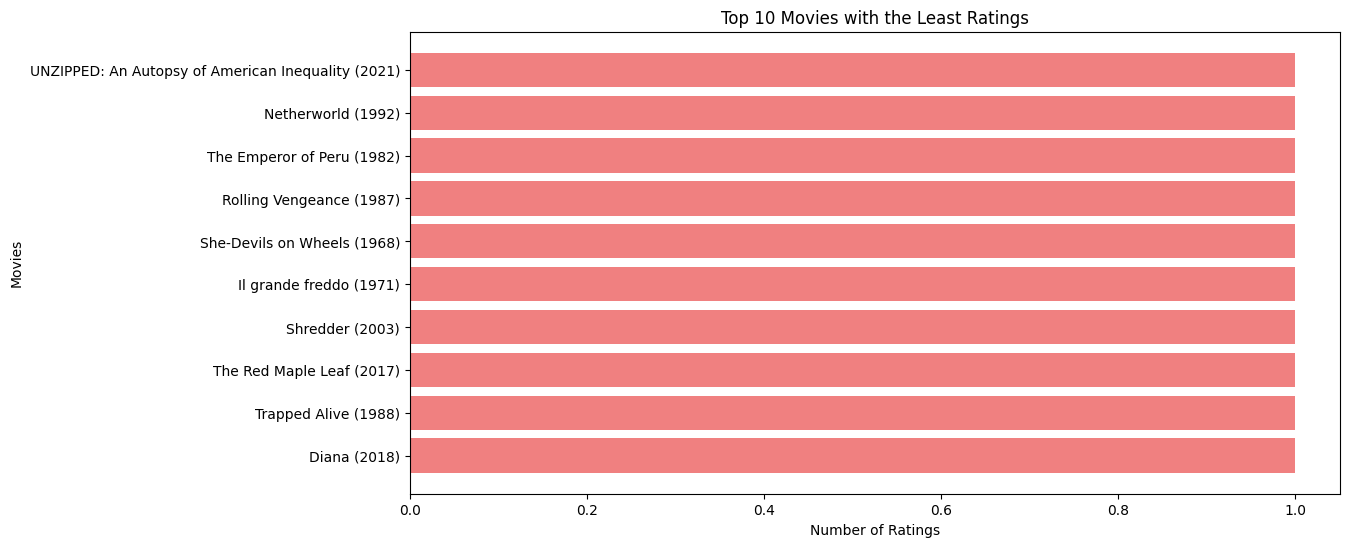

In [7]:
#Movies with least ratings. could also be least viewed?
bottom_movies = movie_ratings.sort_values(by='count', ascending=True).head(10)


plt.figure(figsize=(12, 6))
plt.barh(bottom_movies['title'], bottom_movies['count'], color='lightcoral')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.title('Top 10 Movies with the Least Ratings')
plt.gca().invert_yaxis()  # This inverts the y-axis so the movie with the least ratings is at the bottom
plt.show()

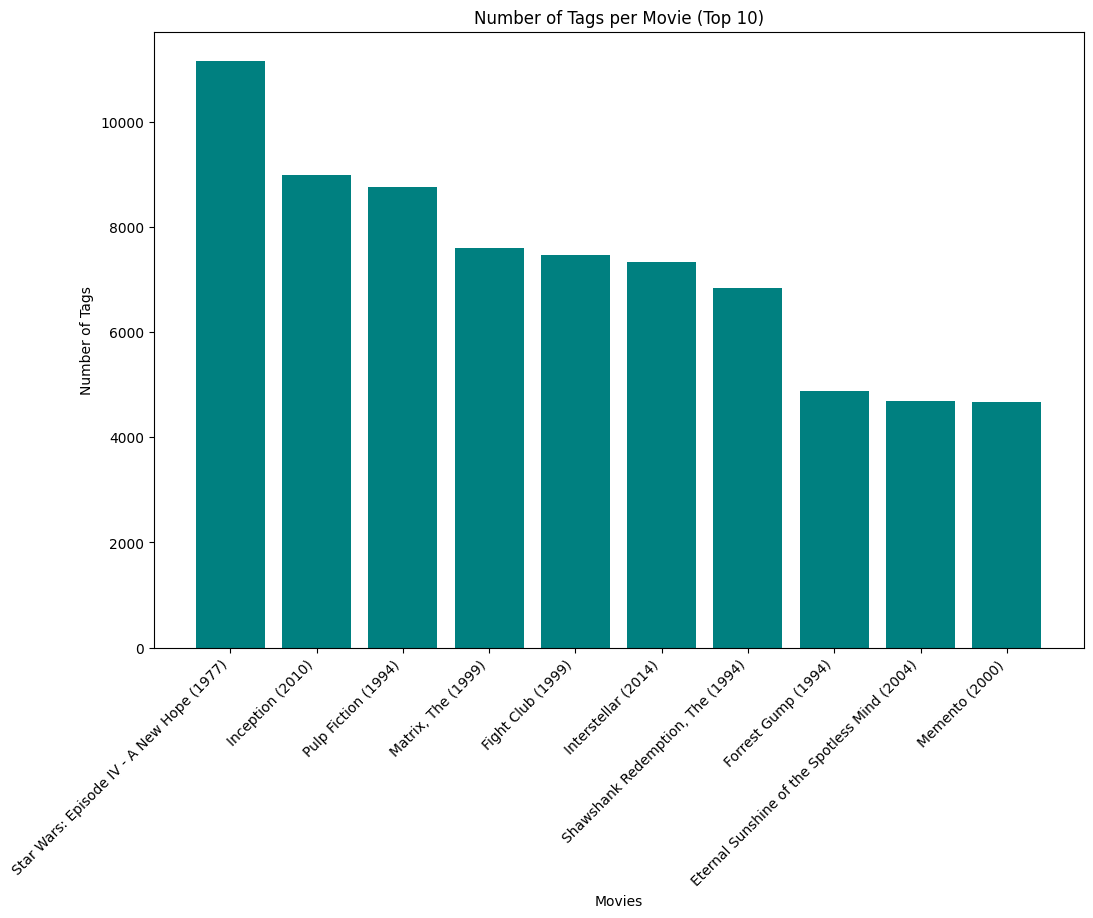

In [8]:
#amount of tags per movie. top 10
df_tags = pd.read_csv('ml-latest/tags.csv', usecols=['movieId', 'tag'])

tag_counts = df_tags.groupby('movieId').size().reset_index(name='count')

movie_tags = pd.merge(df_movies, tag_counts, on='movieId', how='left').fillna(0)


movie_tags_sorted = movie_tags.sort_values(by='count', ascending=False)

#plot the top 10 movies with the most tags
plt.figure(figsize=(12, 8))
plt.bar(movie_tags_sorted['title'].head(10), movie_tags_sorted['count'].head(10), color='teal')
plt.xlabel('Movies')
plt.ylabel('Number of Tags')
plt.title('Number of Tags per Movie (Top 10)')
plt.xticks(rotation=45, ha='right')
plt.show()

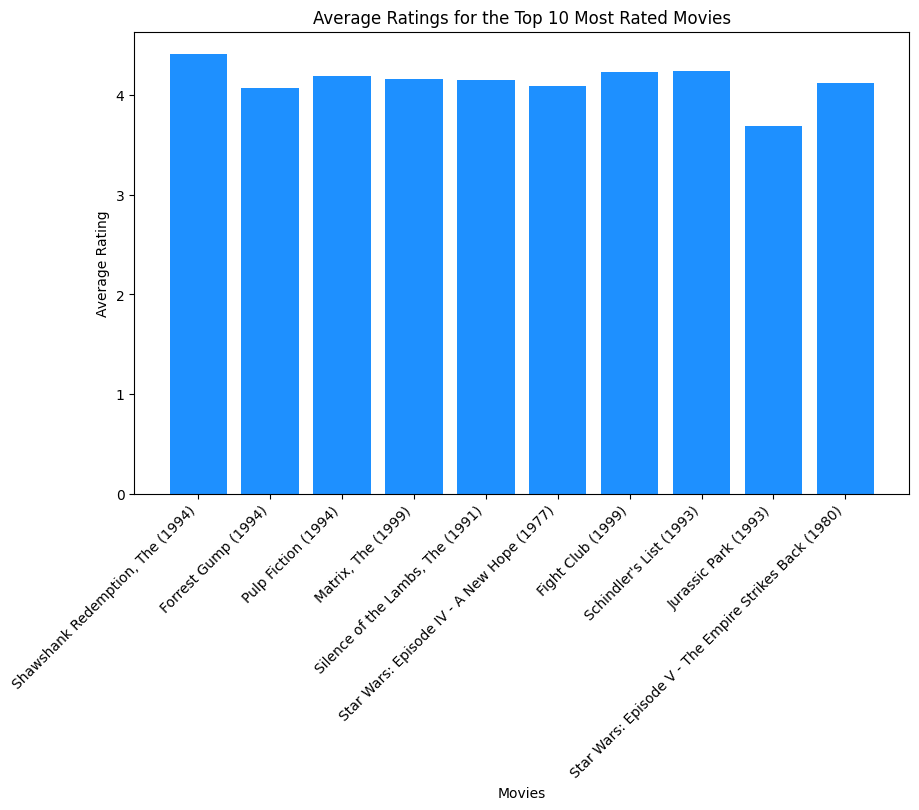

In [9]:
#average ratings for the top 10 most rated movies. 

rating_counts = df_ratings.groupby('movieId').size().reset_index(name='count')
movie_ratings = pd.merge(df_movies, rating_counts, on='movieId')
top_movies = movie_ratings.sort_values(by='count', ascending=False).head(10)
top_movies_ratings = df_ratings[df_ratings['movieId'].isin(top_movies['movieId'])]
average_ratings = top_movies_ratings.groupby('movieId').rating.mean().reset_index()
average_ratings_with_titles = pd.merge(top_movies[['movieId', 'title']], average_ratings, on='movieId')

plt.figure(figsize=(10, 6))
plt.bar(average_ratings_with_titles['title'], average_ratings_with_titles['rating'], color='dodgerblue')
plt.xlabel('Movies')
plt.ylabel('Average Rating')
plt.title('Average Ratings for the Top 10 Most Rated Movies')
plt.xticks(rotation=45, ha='right')
plt.show()


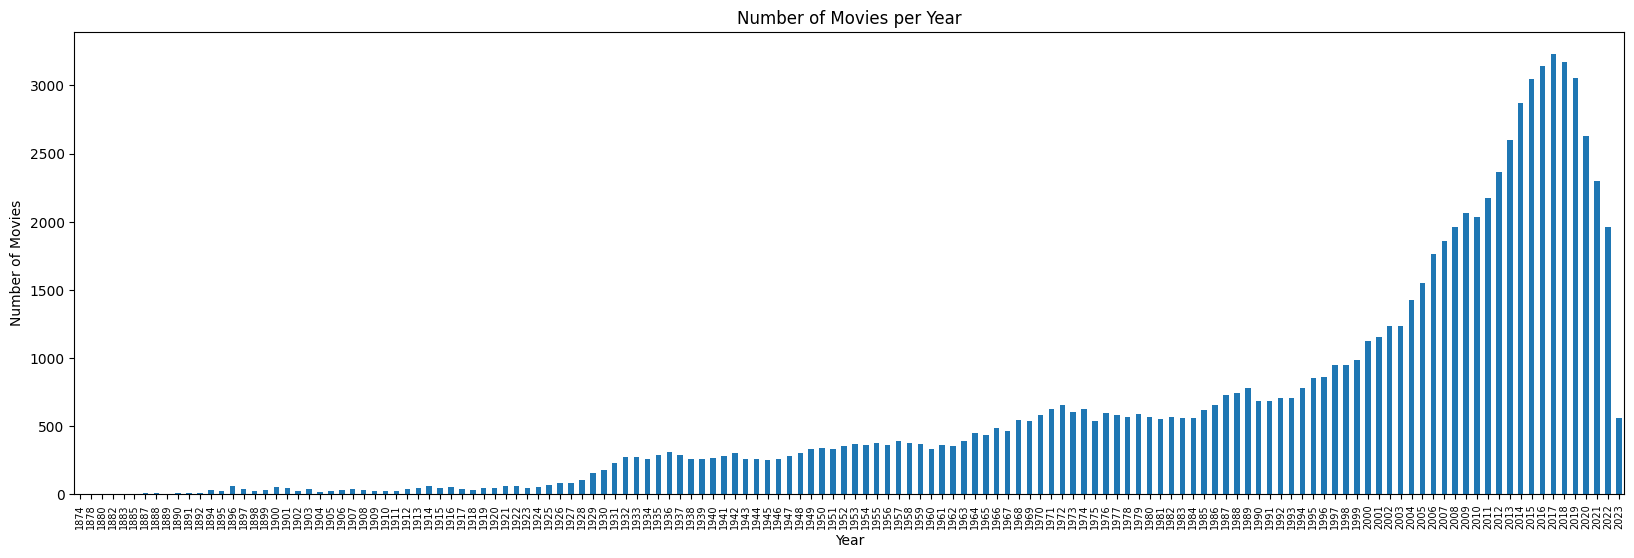

In [10]:
# Plotting the number of movies by year

df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)$')
# Count the number of movies per year
movies_per_year = df_movies['year'].value_counts().sort_index()
# Plot
plt.figure(figsize=(20, 6))
movies_per_year.plot(kind='bar')
plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tick_params(axis='x', labelsize=7)
plt.show()

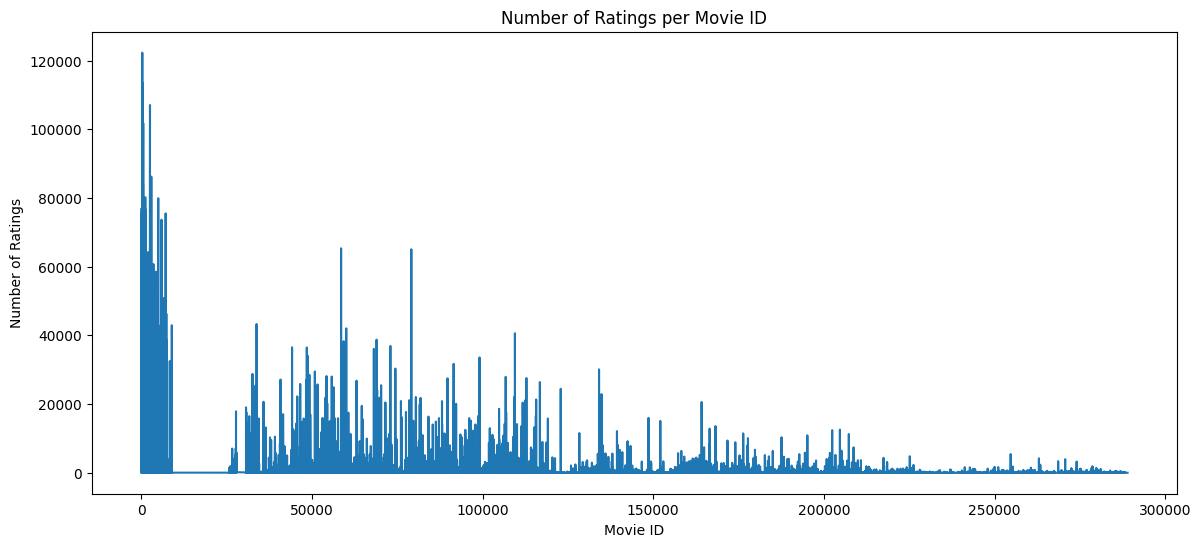

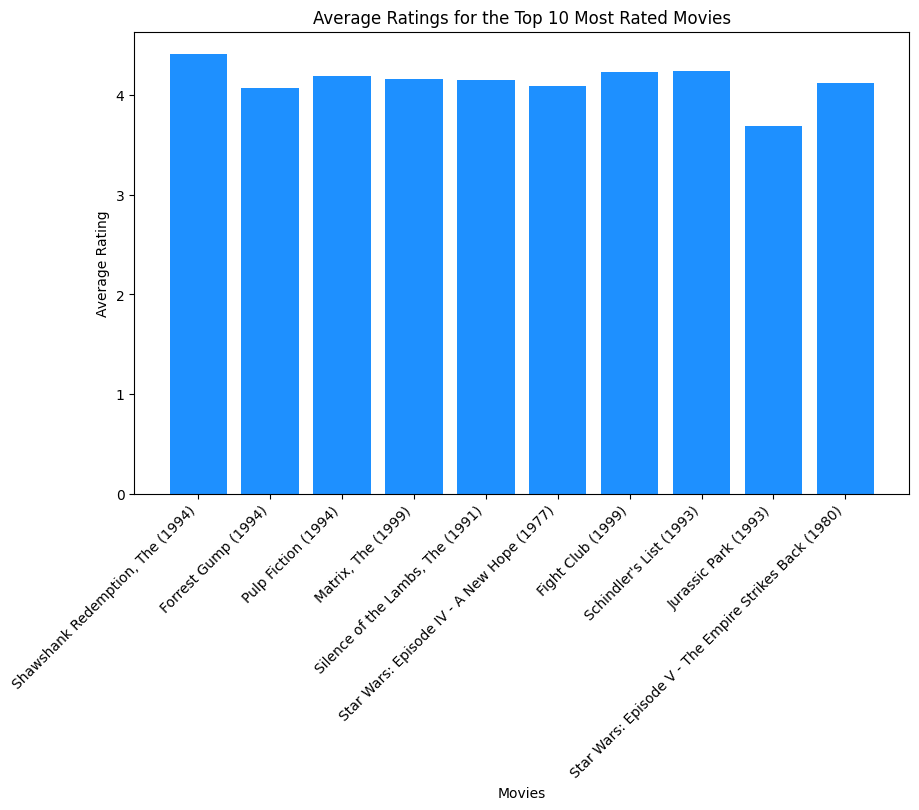

In [11]:
# Number of Ratings vs. Movie ID
ratings_per_movie = df_ratings['movieId'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
ratings_per_movie.plot()
plt.title('Number of Ratings per Movie ID')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

rating_counts = df_ratings.groupby('movieId').size().reset_index(name='count')
movie_ratings = pd.merge(df_movies, rating_counts, on='movieId')
top_movies = movie_ratings.sort_values(by='count', ascending=False).head(10)
top_movies_ratings = df_ratings[df_ratings['movieId'].isin(top_movies['movieId'])]
average_ratings = top_movies_ratings.groupby('movieId').rating.mean().reset_index()
average_ratings_with_titles = pd.merge(top_movies[['movieId', 'title']], average_ratings, on='movieId')

#same as earlier?
plt.figure(figsize=(10, 6))
plt.bar(average_ratings_with_titles['title'], average_ratings_with_titles['rating'], color='dodgerblue')
plt.xlabel('Movies')
plt.ylabel('Average Rating')
plt.title('Average Ratings for the Top 10 Most Rated Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

1.2 Glesmatris

In [12]:

movies = 'ml-latest/movies.csv'
df_movies = pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})  

ratings = 'ml-latest/ratings.csv'
df_ratings = pd.read_csv(ratings, usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})  

min_reviews = 50
filter_movies = df_ratings['movieId'].value_counts() > min_reviews
filter_movies = filter_movies[filter_movies].index.tolist()


filtered_df = df_ratings[df_ratings['movieId'].isin(filter_movies)]

user_ids = filtered_df['userId'].astype('category').cat.codes
movie_ids = filtered_df['movieId'].astype('category').cat.codes
ratings = filtered_df['rating']

num_users = user_ids.max() + 1
num_movies = movie_ids.max() + 1

sparse_matrix = csr_matrix((ratings, (user_ids, movie_ids)), shape=(num_users, num_movies))

print(f"Shape of the sparse matrix: {sparse_matrix.shape}")
print(f"Number of non-zero elements: {sparse_matrix.nnz}")

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

model_knn.fit(sparse_matrix)

coo_matrix = sparse_matrix.tocoo()




Shape of the sparse matrix: (330760, 15989)
Number of non-zero elements: 33326561


sparse matrix: 
- used with analysis of data with a low density of significant data. 
- uses the 0-elements as "the canvas" and the non-zero as "paint" or "pixels"
-  0 0 0 0 7 6 
-  0 0 0 5 4 0
-  0 0 5 9 0 0
-  0 9 3 0 0 0
- ^ kinda like that

1.3 Recommender system
Skapa ett recommender system med KNN och låt systemet ta input från användaren och skriva ut top 5
rekommenderade filmerna, baserat på användarens sökquery. Observera att det finns ett logiskt fel i
videon som gör att rekommendationerna inte blir så bra, försök hitta felet och åtgärda det.

a) Beskriv med ord hur ditt system fungerar.

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.

In [14]:
df_tags = pd.read_csv('ml-latest/tags.csv')
df_tags['tag'] = df_tags['tag'].str.lower()  
df_tags['tag'] = df_tags['tag'].str.replace(r'[^\w\s]', '', regex=True)  
combined_tags = df_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x.dropna())).reset_index()

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000) 
tfidf_matrix = vectorizer.fit_transform(combined_tags['tag'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [32]:

df_movies = pd.read_csv('ml-latest/movies.csv')
df_movies = df_movies.merge(combined_tags, on='movieId')

def get_recommendations(movie_title, num_recommendations=5):
    choices = df_movies['title'].tolist()
    best_match = process.extractOne(movie_title, choices)
    if not best_match:
        return f"No movie found with a close title to '{movie_title}'. Please check the title."
    best_match_title = best_match[0]
    idx = df_movies.index[df_movies['title'] == best_match_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]  
    movie_indices = [i[0] for i in sim_scores]
    return df_movies.iloc[movie_indices][['movieId', 'title']]



get_recommendations('matrix, The', 5)


,movieId,title
5977,6365,"Matrix Reloaded, The (2003)"
6521,6934,"Matrix Revolutions, The (2003)"
6384,6790,Avalon (2001)
2446,2672,"Thirteenth Floor, The (1999)"
1900,2105,Tron (1982)


My recommender system is based on using "tags" as opposed to "ratings" like the sample video. My thought process was that it felt more logical to base the recommendations on Tags. Then it would recommend the user movies in the same "genre" or something close. I missed that the df_movie indeed DOES have a column for genre. My intent was to use Tags as some kind of pseodunym to "genre". 
After some mentoring by my teacher i learned that most recommender-systems use many different steps of filtering such as ratings, genre, and tags. I believe using these three would make a decent recommender-system as ratings and genre can work as an objective filter. Meanwhile tags would become more flavoring from the movie buffs in MovieLens.com since the tags are added manually from the users.

My recommender system starts by reading and cleaning the data. It then groups all tags by "movieId" so that the tags from the same movieId are clustered.
Next it uses TF-IDF Vectorization. The TfidfVectorizer is used to convert the combined tags into a numerical format that can be used for machine learning. TF-IDF stands for "Term Frequency-Inverse Document Frequency," a common technique in text mining that reflects how important a word is to a document in a collection. This transformation helps to down-weight the importance of common words (like 'the') across all documents. It then limits the number of features to the top 1000 terms based on term frequency across the dataset. This helps in focusing on the most relevant terms and reduces the computational complexity. Next it computes a cosine similarity matrix between all pair of movies based on their TF-IDF vectors. Cosine similarity measures the cosine of the angle between two vectors, providing a metric that judges how similar two documents (in this case, movies based on tags) are irrespective of their size. It then reads and merges df_movies with combined_tags on movieId column.

With this done the file is ready for the function. Firstly, the function takes two parameters, the movies title and the amount of recommendations shown. It then creates a list of all movie titles to serve as potential matches. Next it uses fuzzy string matching to handle minor misspellings or variations in movie titles. The next line is a simple error handler incase there is no matching movie found. Once a match is found, the function retrieves the index of this movie in the original dataframe, df_movies. Next it retrieves the similarity scores from the cosine similary matrix, sorts the results based on the most similarity score, and finally selects the top 6 results. The function excludes the first entry as it is always going to be the same movie the user inputs into the function.
Making it list the top 5 recommended movied based on tags. 


What is a Recommender System and how does it work?

Recommendation Systems are a type of information system used to predict and suggest items that might be of interest to users. They are commonly used across various platforms such as streaming services (Netflix, Spotify), e-commerce websites (Amazon, Alibaba), and social media platforms (Facebook, Twitter). The goal is to personalize the user experience by offering content or products based on the user's past behavior and preferences.

Recommendation systems start by collecting data, either explicitly through user ratings and reviews or implicitly by tracking user behaviors such as past purchases or viewed items. The next step is to analyze the collected data. This may involve identifying patterns, categorizing items, or even using more advanced methods such as machine learning to understand user preferences. Based on the analysis, various algorithms are used to generate recommendations. There are three main types of recommendation techniques:
- Content-Based Filtering: These systems recommend items that are similar to other items the user has previously liked. For example, if a user has watched many action movies, the system would recommend other movies in the same genre.
- Collaborative Filtering: This method uses information from many users to make recommendations based on similar user behaviors. If two users have a similar taste history, items liked by one user can be recommended to the other.
- Hybrid Models: These combine content-based and collaborative filtering to take advantage of the strengths of both methods and minimize their weaknesses.
Evaluation: Finally, the performance of the system is evaluated to ensure that the recommendations are relevant and effective. This can be done by measuring how well the recommendations lead to desired user behavior, such as purchases, clicks, or viewing time.


Sources:

Article from Geeksforgeeks explaining recommender systems in python:
https://www.geeksforgeeks.org/recommendation-system-in-python/ 

Article written by Francesco Casalegno in 2022, published in towardsdatascience.com:
https://towardsdatascience.com/recommender-systems-a-complete-guide-to-machine-learning-models-96d3f94ea748  <--- incredibly simple explanation with pictures

Index mismatch

pivot-egna df_movie stämmer inte överens. 
Några filmer saknas.
rensa filmer. rensa samma filmer i df_ratings

get_rec + rec från u-tube. 

tags sedan ratings_profile

